In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score,auc
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from scipy.sparse import hstack,csr_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample
import seaborn as sns

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Loading & Preprocessing

In [60]:

data=pd.read_csv('Donors_choose_preprocessed_data.csv',na_filter=False)
#data=data.sample(1000)
y=data['project_is_approved'].values

train,valid=train_test_split(data,test_size=0.2,stratify=y,random_state=4)
y=train['project_is_approved'].values
train,test=train_test_split(train,test_size=0.2,stratify=y,random_state=4)


y_train=train['project_is_approved'].values
x_train=train.drop(['project_is_approved'],axis=1)

y_valid=valid['project_is_approved'].values
x_valid=valid.drop(['project_is_approved'],axis=1)

y_test=test['project_is_approved'].values
x_test=test.drop(['project_is_approved'],axis=1)





In [61]:
essays=x_train['essay']
train_essay_text=' '.join(essays)
words=train_essay_text.split(" ")
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

from collections import Counter
counts=Counter(words)
vocab=sorted(counts,key=counts.get,reverse=True)
vocab=glove_words.intersection(vocab)
int_to_vocab = {ii:word  for ii, word in enumerate(vocab,1)}
vocab_to_int={word:ii  for ii, word in enumerate(vocab,1)}
train_essay_ints = []
for essay in essays:
    train_essay_ints.append([vocab_to_int[word] for word in essay.split() if word in vocab])

essays=x_valid['essay']
valid_essay_ints = []
for essay in essays:
    valid_essay_ints.append([vocab_to_int[word] for word in essay.split() if word in vocab])

essays=x_test['essay']
test_essay_ints = []
for essay in essays:
    test_essay_ints.append([vocab_to_int[word] for word in essay.split() if word in vocab])




In [62]:
#for fixed length input
def pad_features(essay_ints, seq_length):
    
    features = np.zeros((len(essay_ints), seq_length), dtype=int)

    
    for i, row in enumerate(essay_ints):
        if len(row)==0:
            continue
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features


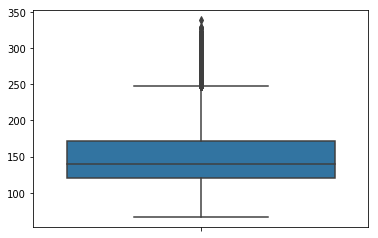

In [63]:
essay_lengths=[len(essay) for essay in train_essay_ints]
sns.boxplot(essay_lengths,orient='v')

In [64]:
#choosing sequenth length=170 as 75% of the essays contains 170 words
seq_length = 170

train_features = pad_features(train_essay_ints, seq_length=seq_length)
valid_features=pad_features(valid_essay_ints, seq_length=seq_length)
test_features=pad_features(test_essay_ints, seq_length=seq_length)


assert len(train_features)==len(train_essay_ints)
assert len(train_features[0])==seq_length



In [65]:
weight_matrix=np.random.normal(size=(len(vocab)+1,300))
for i in range(1,len(vocab)+1):
    weight_matrix[i]=model[int_to_vocab[i]]

In [66]:
values=x_train['school_state']
counts=Counter(values)
vocab=sorted(counts,key=counts.get,reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab,1)}
train_school_state_ints=[vocab_to_int[word] for word in values]

values=x_valid['school_state']
valid_school_state_ints=[vocab_to_int[word] if word in vocab else 0 for word in values]

values=x_test['school_state']
test_school_state_ints=[vocab_to_int[word] if word in vocab else 0 for word in values]
len_ss_vocab=len(vocab)+1

In [67]:
values=x_train['project_grade_category']
counts=Counter(values)
vocab=sorted(counts,key=counts.get,reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab,1)}
train_grades_ints=[vocab_to_int[word] for word in values]

values=x_valid['project_grade_category']
valid_grades_ints=[vocab_to_int[word] if word in vocab else 0 for word in values]
values=x_test['project_grade_category']
test_grades_ints=[vocab_to_int[word] if word in vocab else 0 for word in values]
len_pg_vocab=len(vocab)+1

In [68]:
values=x_train['project_subject_categories']
counts=Counter(values)
vocab=sorted(counts,key=counts.get,reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab,1)}
train_categories_ints=[vocab_to_int[word] for word in values]

values=x_valid['project_subject_categories']
valid_categories_ints=[vocab_to_int[word] if word in vocab else 0 for word in values]

values=x_test['project_subject_categories']
test_categories_ints=[vocab_to_int[word] if word in vocab else 0 for word in values]
len_sc_vocab=len(vocab)+1

In [69]:
values=x_train['project_subject_subcategories']
counts=Counter(values)
vocab=sorted(counts,key=counts.get,reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab,1)}
train_sub_categories_ints=[vocab_to_int[word] for word in values]

values=x_valid['project_subject_subcategories']
valid_sub_categories_ints=[vocab_to_int[word] if word in vocab else 0 for word in values]

values=x_test['project_subject_subcategories']
test_sub_categories_ints=[vocab_to_int[word] if word in vocab else 0 for word in values]
len_ssc_vocab=len(vocab)+1

In [70]:
values=x_train['teacher_prefix']
counts=Counter(values)
vocab=sorted(counts,key=counts.get,reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab,1)}
train_teacher_ints=[vocab_to_int[word] for word in values]

values=x_valid['teacher_prefix']
valid_teacher_ints=[vocab_to_int[word] if word in vocab else 0 for word in values]
values=x_test['teacher_prefix']
test_teacher_ints=[vocab_to_int[word] if word in vocab else 0 for word in values]
len_tp_vocab=len(vocab)+1

In [71]:
def check_digits(value):
    for word in value.split():
        if word.isdigit():
            return 1
    return 0

standardscalar=StandardScaler()#standardizing data
train_prev_projects=np.array(x_train['teacher_number_of_previously_posted_projects']).reshape(-1,1)
train_prev_projects=standardscalar.fit_transform(train_prev_projects)
valid_prev_projects=np.array(x_valid['teacher_number_of_previously_posted_projects']).reshape(-1,1)
valid_prev_projects=standardscalar.transform(valid_prev_projects)
test_prev_projects=np.array(x_test['teacher_number_of_previously_posted_projects']).reshape(-1,1)
test_prev_projects=standardscalar.transform(test_prev_projects)


train_price=np.array(x_train['price']).reshape(-1,1)
train_price=standardscalar.fit_transform(train_price)
valid_price=np.array(x_valid['price']).reshape(-1,1)
valid_price=standardscalar.transform(valid_price)
test_price=np.array(x_test['price']).reshape(-1,1)
test_price=standardscalar.transform(test_price)


train_quantity=np.array(x_train['quantity']).reshape(-1,1)
train_quantity=standardscalar.fit_transform(train_quantity)
valid_quantity=np.array(x_valid['quantity']).reshape(-1,1)
valid_quantity=standardscalar.transform(valid_quantity)
test_quantity=np.array(x_test['quantity']).reshape(-1,1)
test_quantity=standardscalar.transform(test_quantity)
                                      
train_summary_contains_digits=np.array(x_train['project_resource_summary'].map(check_digits)).reshape(-1,1)
valid_summary_contains_digits=np.array(x_valid['project_resource_summary'].map(check_digits)).reshape(-1,1)
test_summary_contains_digits=np.array(x_test['project_resource_summary'].map(check_digits)).reshape(-1,1)

train_remain_features=np.concatenate((train_prev_projects,train_price,train_quantity,train_summary_contains_digits),axis=1)
valid_remain_features=np.concatenate((valid_prev_projects,valid_price,valid_quantity,valid_summary_contains_digits),axis=1)
test_remain_features=np.concatenate((test_prev_projects,test_price,test_quantity,test_summary_contains_digits),axis=1)



In [72]:
train_essay_ints=torch.from_numpy(train_features).to(device)
train_school_state_ints=torch.from_numpy(np.array(train_school_state_ints)).to(device)
train_grades_ints=torch.from_numpy(np.array(train_grades_ints)).to(device)
train_categories_ints=torch.from_numpy(np.array(train_categories_ints)).to(device)
train_sub_categories_ints=torch.from_numpy(np.array(train_sub_categories_ints)).to(device)
train_teacher_ints=torch.from_numpy(np.array(train_teacher_ints)).to(device)
train_remain_features=torch.from_numpy(train_remain_features).to(device)
train_expected=torch.from_numpy(y_train).to(device)



valid_essay_ints=torch.from_numpy(valid_features).to(device)
valid_school_state_ints=torch.from_numpy(np.array(valid_school_state_ints)).to(device)
valid_grades_ints=torch.from_numpy(np.array(valid_grades_ints)).to(device)
valid_categories_ints=torch.from_numpy(np.array(valid_categories_ints)).to(device)
valid_sub_categories_ints=torch.from_numpy(np.array(valid_sub_categories_ints)).to(device)
valid_teacher_ints=torch.from_numpy(np.array(valid_teacher_ints)).to(device)
valid_remain_features=torch.from_numpy(valid_remain_features).to(device)
valid_expected=torch.from_numpy(y_valid).to(device)


test_essay_ints=torch.from_numpy(test_features).to(device)
test_school_state_ints=torch.from_numpy(np.array(test_school_state_ints)).to(device)
test_grades_ints=torch.from_numpy(np.array(test_grades_ints)).to(device)
test_categories_ints=torch.from_numpy(np.array(test_categories_ints)).to(device)
test_sub_categories_ints=torch.from_numpy(np.array(test_sub_categories_ints)).to(device)
test_teacher_ints=torch.from_numpy(np.array(test_teacher_ints)).to(device)
test_remain_features=torch.from_numpy(test_remain_features).to(device)
test_expected=torch.from_numpy(y_test).to(device)

In [73]:
batch_size=32
def get_batches(inp,x1,x2,x3,x4,x5,rem,y):
    total_length=len(inp)
    num_batch=total_length//batch_size
    total_length=num_batch*batch_size
    inp=inp[:total_length]
    x1=x1[:total_length]
    x2=x2[:total_length]
    x3=x3[:total_length]
    x4=x4[:total_length]
    x5=x5[:total_length]
    rem=rem[:total_length]
    y=y[:total_length]
    
    for i in range(num_batch):
        start=i*batch_size
        end=start+batch_size
        yield inp[start:end],x1[start:end],x2[start:end],x3[start:end],x4[start:end],x5[start:end],rem[start:end],y[start:end]
        
    

# 2.LSTM Model Building (model-1)

In [74]:
def create_emb_layer(weights_matrix, non_trainable=False):
    #to create embedding layer with our pre trained weights(in this case word vectors)
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class Net(nn.Module):
    def __init__(self, weights_matrix,l1,l2,l3,l4,l5,hidden_size,num_layers):
        super().__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix,True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb1=nn.Embedding(l1,50)
        self.emb2=nn.Embedding(l2,10)
        self.emb3=nn.Embedding(l3,50)
        self.emb4=nn.Embedding(l4,50)
        self.emb5=nn.Embedding(l5,10)
        self.dense=nn.Linear(4,20)
        self.dense2=nn.Linear(340,100)
        self.dense3=nn.Linear(100,30)
        self.dense4=nn.Linear(30,1)
        self.dropout=nn.Dropout(0.2)
        self.sigmoid=nn.Sigmoid()
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        
    def forward(self,inp,x1,x2,x3,x4,x5,rem,hidden):
        inp,hidden=self.lstm(self.embedding(inp),hidden)
        inp=inp[:,-1,:]
        x1=self.emb1(x1)
        x2=self.emb2(x2)
        x3=self.emb3(x3)
        x4=self.emb4(x4)
        x5=self.emb5(x5)
        rem=self.dense(rem)
        lstm_out = inp.contiguous().view(-1, self.hidden_size) # stack up lstm outputs
        features=torch.cat((inp,x1,x2,x3,x4,x5,rem),1)
        features=self.dropout(features)
        features=self.dense2(features)
        features=self.dropout(features)
        features=self.dense3(features)
        features=self.dense4(features)
        features=self.sigmoid(features)    
        return features
    
    
    def init_hidden(self, batch_size):
        hidden=torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device),torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)
        return hidden

In [75]:
net=Net(torch.from_numpy(weight_matrix),len_ss_vocab,len_pg_vocab,len_sc_vocab,len_ssc_vocab,len_tp_vocab,150,2)
lr=0.001
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(net.parameters(), lr=lr,momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
net.to(device)

Net(
  (embedding): Embedding(42559, 300)
  (emb1): Embedding(52, 50)
  (emb2): Embedding(5, 10)
  (emb3): Embedding(51, 50)
  (emb4): Embedding(388, 50)
  (emb5): Embedding(7, 10)
  (dense): Linear(in_features=4, out_features=20, bias=True)
  (dense2): Linear(in_features=340, out_features=100, bias=True)
  (dense3): Linear(in_features=100, out_features=30, bias=True)
  (dense4): Linear(in_features=30, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
  (sigmoid): Sigmoid()
  (lstm): LSTM(300, 150, num_layers=2, batch_first=True)
)

### Parameters of Model

In [76]:
for p in net.parameters():
    print('number of parametrs: {:10} trainable:{}'.format(p.numel(),p.requires_grad))
total_trainable_params=sum(p.numel() for p in net.parameters() if p.requires_grad)

print('total trainable parameters:',total_trainable_params)

number of parametrs:   12767700 trainable:False
number of parametrs:       2600 trainable:True
number of parametrs:         50 trainable:True
number of parametrs:       2550 trainable:True
number of parametrs:      19400 trainable:True
number of parametrs:         70 trainable:True
number of parametrs:         80 trainable:True
number of parametrs:         20 trainable:True
number of parametrs:      34000 trainable:True
number of parametrs:        100 trainable:True
number of parametrs:       3000 trainable:True
number of parametrs:         30 trainable:True
number of parametrs:         30 trainable:True
number of parametrs:          1 trainable:True
number of parametrs:     180000 trainable:True
number of parametrs:      90000 trainable:True
number of parametrs:        600 trainable:True
number of parametrs:        600 trainable:True
number of parametrs:      90000 trainable:True
number of parametrs:      90000 trainable:True
number of parametrs:        600 trainable:True
number of pa

epoch :  1 train_loss :   0.401659 valid_loss:   0.390410 train_auc   0.670262 val_auc   0.720499 
epoch :  2 train_loss :   0.377198 valid_loss:   0.383432 train_auc   0.732764 val_auc   0.741889 
epoch :  3 train_loss :   0.366334 valid_loss:   0.378093 train_auc   0.755036 val_auc   0.746224 
epoch :  4 train_loss :   0.353066 valid_loss:   0.384970 train_auc   0.779483 val_auc   0.740868 
epoch :  5 train_loss :   0.331604 valid_loss:   0.406734 train_auc   0.814132 val_auc   0.721087 
epoch :  6 train_loss :   0.298384 valid_loss:   0.461938 train_auc   0.856597 val_auc   0.693813 
epoch :  7 train_loss :   0.254550 valid_loss:   0.529844 train_auc   0.901776 val_auc   0.676336 
epoch :  8 train_loss :   0.212122 valid_loss:   0.640464 train_auc   0.935336 val_auc   0.668497 
epoch :  9 train_loss :   0.173877 valid_loss:   0.700007 train_auc   0.958510 val_auc   0.664803 
epoch : 10 train_loss :   0.141228 valid_loss:   0.814980 train_auc   0.973324 val_auc   0.660063 


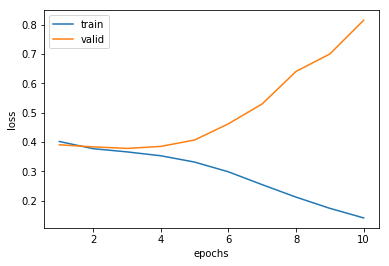

In [77]:
epochs=10
epoch_train_loss=[]
epoch_valid_loss=[]
best_loss=np.inf
for epoch in (range(epochs)):
    hidden=net.init_hidden(batch_size)
    train_loss=0
    valid_loss=0
    batch=0
    net.train()
    ypr=[]
    for a1,a2,a3,a4,a5,a6,a7,labels in get_batches(train_essay_ints,train_school_state_ints,train_grades_ints,train_categories_ints,train_sub_categories_ints,train_teacher_ints,train_remain_features,train_expected):
        batch+=1
        net.zero_grad()
        a7=a7.float()
        #hidden=tuple([each.data for each in hidden])
        hidden=net.init_hidden(batch_size)
        out=net(a1,a2,a3,a4,a5,a6,a7,hidden)
        loss = criterion(out.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(),5)#gradient clipping
        optimizer.step()
        train_loss+=loss.item()
        out=out.cpu().detach().numpy()
        ypr.extend(list(out.squeeze()))
    train_auc=roc_auc_score(y_train[:len(ypr)],ypr)
    train_loss/=batch
    epoch_train_loss.append(train_loss)
    net.eval()
    batch=0
    ypr=[]
    with torch.no_grad():
        hidden=net.init_hidden(batch_size)
        for a1,a2,a3,a4,a5,a6,a7,labels in get_batches(valid_essay_ints,valid_school_state_ints,valid_grades_ints,valid_categories_ints,valid_sub_categories_ints,valid_teacher_ints,valid_remain_features,valid_expected):
            batch+=1
            #hidden=tuple([each.data for each in hidden])
            hidden=net.init_hidden(batch_size)
            a7=a7.float()
            out=net(a1,a2,a3,a4,a5,a6,a7,hidden)
            loss = criterion(out.squeeze(), labels.float())
            valid_loss+=loss.item()
            out=out.cpu().detach().numpy()
            ypr.extend(list(out.squeeze()))
        val_auc=roc_auc_score(y_valid[:len(ypr)],ypr)
        valid_loss/=batch
        if best_loss>valid_loss:
                torch.save(net,'best_model1.pth')
                best_loss=valid_loss
        epoch_valid_loss.append(valid_loss)
        print('epoch : {:2} train_loss : {:10.6f} valid_loss: {:10.6f} train_auc {:10.6f} val_auc {:10.6f} '.format(epoch+1,train_loss,valid_loss,train_auc,val_auc))
    
    
plt.plot(range(1,epochs+1),epoch_train_loss,label='train')
plt.plot(range(1,epochs+1),epoch_valid_loss,label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

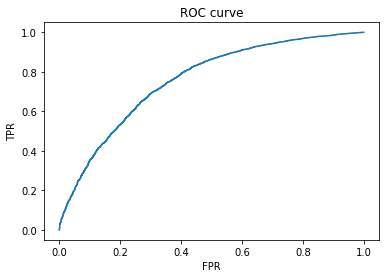

area under curve is 0.7569791889649025


In [78]:
net=torch.load('best_model1.pth')
y_pred=[]
with torch.no_grad():
    hidden=net.init_hidden(batch_size)
    for a1,a2,a3,a4,a5,a6,a7,labels in get_batches(test_essay_ints,test_school_state_ints,test_grades_ints,test_categories_ints,test_sub_categories_ints,test_teacher_ints,test_remain_features,test_expected):
            batch+=1
            #hidden=tuple([each.data for each in hidden])
            hidden=net.init_hidden(batch_size)
            a7=a7.float()
            out=net(a1,a2,a3,a4,a5,a6,a7,hidden).cpu().detach().numpy()
            y_pred.extend(list(out.squeeze()))
test_fpr, test_tpr, te_thresholds = roc_curve(y_test[:len(y_pred)], y_pred)
plt.plot(test_fpr,test_tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()
model1_auc=roc_auc_score(y_test[:len(y_pred)],y_pred)
print("area under curve is "+str(model1_auc))

# 3. LSTM Model - 2

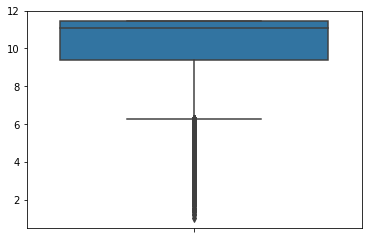

In [79]:
essays=x_train['essay']
tfidf_vect=TfidfVectorizer()
essays_vect=tfidf_vect.fit_transform(essays)
import seaborn as sns
sns.boxplot(tfidf_vect.idf_,orient='v')

In [80]:
lower_limit=np.percentile(tfidf_vect.idf_,25);higher_limit=np.percentile(tfidf_vect.idf_,75)
vocab_dict=dict(zip(tfidf_vect.get_feature_names(),tfidf_vect.idf_))
vocab=[word for word,idf in vocab_dict.items() if idf<lower_limit or idf>higher_limit ]


In [81]:

vocab=glove_words.intersection(vocab)
int_to_vocab = {ii:word  for ii, word in enumerate(vocab,1)}
vocab_to_int={word:ii  for ii, word in enumerate(vocab,1)}
essays=x_train['essay']


train_essay_ints=[]
for essay in essays:
    train_essay_ints.append([vocab_to_int[word] for word in essay.split() if word in vocab])
    

essays=x_valid['essay']
valid_essay_ints=[]
for essay in essays:
    valid_essay_ints.append([vocab_to_int[word] for word in essay.split() if word in vocab])
essays=x_test['essay']
test_essay_ints=[]
for essay in essays:
    test_essay_ints.append([vocab_to_int[word] for word in essay.split() if word in vocab])


In [82]:
seq_length =150

train_features = pad_features(train_essay_ints, seq_length=seq_length)
valid_features=pad_features(valid_essay_ints, seq_length=seq_length)
test_features=pad_features(test_essay_ints, seq_length=seq_length)
weight_matrix=np.random.normal(size=(len(vocab)+1,300))
for i in range(1,len(vocab)+1):
    weight_matrix[i]=model[int_to_vocab[i]]

test_essay_ints=torch.from_numpy(test_features).to(device)
valid_essay_ints=torch.from_numpy(valid_features).to(device)
train_essay_ints=torch.from_numpy(train_features).to(device)

In [83]:
net=Net(torch.from_numpy(weight_matrix),len_ss_vocab,len_pg_vocab,len_sc_vocab,len_ssc_vocab,len_tp_vocab,150,2)
lr=0.001
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(net.parameters(), lr=lr,momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
net.to(device)

Net(
  (embedding): Embedding(11374, 300)
  (emb1): Embedding(52, 50)
  (emb2): Embedding(5, 10)
  (emb3): Embedding(51, 50)
  (emb4): Embedding(388, 50)
  (emb5): Embedding(7, 10)
  (dense): Linear(in_features=4, out_features=20, bias=True)
  (dense2): Linear(in_features=340, out_features=100, bias=True)
  (dense3): Linear(in_features=100, out_features=30, bias=True)
  (dense4): Linear(in_features=30, out_features=1, bias=True)
  (dropout): Dropout(p=0.2)
  (sigmoid): Sigmoid()
  (lstm): LSTM(300, 150, num_layers=2, batch_first=True)
)

### Parameters of Model

In [84]:
for p in net.parameters():
    print('number of parametrs: {:10} trainable:{}'.format(p.numel(),p.requires_grad))
total_trainable_params=sum(p.numel() for p in net.parameters() if p.requires_grad)

print('total trainable parameters:',total_trainable_params)

number of parametrs:    3412200 trainable:False
number of parametrs:       2600 trainable:True
number of parametrs:         50 trainable:True
number of parametrs:       2550 trainable:True
number of parametrs:      19400 trainable:True
number of parametrs:         70 trainable:True
number of parametrs:         80 trainable:True
number of parametrs:         20 trainable:True
number of parametrs:      34000 trainable:True
number of parametrs:        100 trainable:True
number of parametrs:       3000 trainable:True
number of parametrs:         30 trainable:True
number of parametrs:         30 trainable:True
number of parametrs:          1 trainable:True
number of parametrs:     180000 trainable:True
number of parametrs:      90000 trainable:True
number of parametrs:        600 trainable:True
number of parametrs:        600 trainable:True
number of parametrs:      90000 trainable:True
number of parametrs:      90000 trainable:True
number of parametrs:        600 trainable:True
number of pa

epoch :  1 train_loss :   0.408475 valid_loss:   0.385651 train_auc   0.648510 val_auc   0.718965 
epoch :  2 train_loss :   0.377936 valid_loss:   0.379334 train_auc   0.730292 val_auc   0.741874 
epoch :  3 train_loss :   0.365965 valid_loss:   0.388561 train_auc   0.754597 val_auc   0.739864 
epoch :  4 train_loss :   0.349162 valid_loss:   0.393779 train_auc   0.783821 val_auc   0.730816 
epoch :  5 train_loss :   0.322850 valid_loss:   0.431869 train_auc   0.821276 val_auc   0.712883 
epoch :  6 train_loss :   0.286869 valid_loss:   0.517790 train_auc   0.864270 val_auc   0.694660 
epoch :  7 train_loss :   0.244667 valid_loss:   0.598721 train_auc   0.906133 val_auc   0.671105 
epoch :  8 train_loss :   0.202137 valid_loss:   0.707368 train_auc   0.939618 val_auc   0.661242 
epoch :  9 train_loss :   0.165120 valid_loss:   0.872068 train_auc   0.962033 val_auc   0.649406 
epoch : 10 train_loss :   0.131242 valid_loss:   1.058050 train_auc   0.976453 val_auc   0.646656 


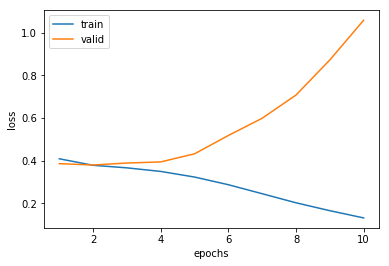

In [85]:
epochs=10
epoch_train_loss=[]
epoch_valid_loss=[]
best_loss=np.inf
for epoch in (range(epochs)):
    hidden=net.init_hidden(batch_size)
    train_loss=0
    valid_loss=0
    batch=0
    net.train()
    ypr=[]
    for a1,a2,a3,a4,a5,a6,a7,labels in get_batches(train_essay_ints,train_school_state_ints,train_grades_ints,train_categories_ints,train_sub_categories_ints,train_teacher_ints,train_remain_features,train_expected):
        batch+=1
        net.zero_grad()
        a7=a7.float()
        #hidden=tuple([each.data for each in hidden])
        hidden=net.init_hidden(batch_size)
        out=net(a1,a2,a3,a4,a5,a6,a7,hidden)
        loss = criterion(out.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(net.parameters(),5)#gradient clipping
        optimizer.step()
        train_loss+=loss.item()
        out=out.cpu().detach().numpy()
        ypr.extend(list(out.squeeze()))
    train_auc=roc_auc_score(y_train[:len(ypr)],ypr)
    train_loss/=batch
    epoch_train_loss.append(train_loss)
    net.eval()
    batch=0
    ypr=[]
    with torch.no_grad():
        hidden=net.init_hidden(batch_size)
        for a1,a2,a3,a4,a5,a6,a7,labels in get_batches(valid_essay_ints,valid_school_state_ints,valid_grades_ints,valid_categories_ints,valid_sub_categories_ints,valid_teacher_ints,valid_remain_features,valid_expected):
            batch+=1
            #hidden=tuple([each.data for each in hidden])
            hidden=net.init_hidden(batch_size)
            a7=a7.float()
            out=net(a1,a2,a3,a4,a5,a6,a7,hidden)
            loss = criterion(out.squeeze(), labels.float())
            valid_loss+=loss.item()
            out=out.cpu().detach().numpy()
            ypr.extend(list(out.squeeze()))
        val_auc=roc_auc_score(y_valid[:len(ypr)],ypr)
        valid_loss/=batch
        if best_loss>valid_loss:
                torch.save(net,'best_model2.pth')
                best_loss=valid_loss
        epoch_valid_loss.append(valid_loss)
        print('epoch : {:2} train_loss : {:10.6f} valid_loss: {:10.6f} train_auc {:10.6f} val_auc {:10.6f} '.format(epoch+1,train_loss,valid_loss,train_auc,val_auc))
    
    
plt.plot(range(1,epochs+1),epoch_train_loss,label='train')
plt.plot(range(1,epochs+1),epoch_valid_loss,label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

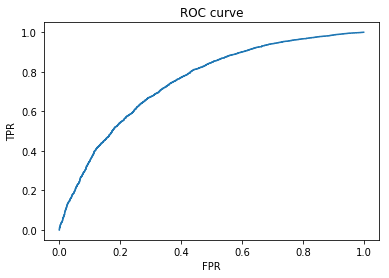

area under curve is 0.7516293335499038


In [86]:
net=torch.load('best_model2.pth')
y_pred=[]
net.eval()
with torch.no_grad():
    hidden=net.init_hidden(batch_size)
    for a1,a2,a3,a4,a5,a6,a7,labels in get_batches(test_essay_ints,test_school_state_ints,test_grades_ints,test_categories_ints,test_sub_categories_ints,test_teacher_ints,test_remain_features,test_expected):
            batch+=1
            hidden=net.init_hidden(batch_size)
            a7=a7.float()
            out=net(a1,a2,a3,a4,a5,a6,a7,hidden).cpu().detach().numpy()
            y_pred.extend(list(out.squeeze()))
test_fpr, test_tpr, te_thresholds = roc_curve(y_test[:len(y_pred)], y_pred)
plt.plot(test_fpr,test_tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()
model2_auc=roc_auc_score(y_test[:len(y_pred)],y_pred)
print("area under curve is "+str(model2_auc))

# 4. LSTM Model- 3

In [97]:
essays=x_train['essay']
train_essay_text=' '.join(essays)
words=train_essay_text.split(" ")
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

from collections import Counter
counts=Counter(words)
vocab=sorted(counts,key=counts.get,reverse=True)
vocab=glove_words.intersection(vocab)
int_to_vocab = {ii:word  for ii, word in enumerate(vocab,1)}
vocab_to_int={word:ii  for ii, word in enumerate(vocab,1)}
train_essay_ints = []
for essay in essays:
    train_essay_ints.append([vocab_to_int[word] for word in essay.split() if word in vocab])


essays=x_valid['essay']
valid_essay_ints=[]
for essay in essays:
    valid_essay_ints.append([vocab_to_int[word] for word in essay.split() if word in vocab])



essays=x_test['essay']
test_essay_ints = []
for essay in essays:
    test_essay_ints.append([vocab_to_int[word] for word in essay.split() if word in vocab])




In [98]:
def pad_features(essay_ints, seq_length):
    
    features = np.zeros((len(essay_ints), seq_length), dtype=int)

    
    for i, row in enumerate(essay_ints):
        if len(row)==0:
            continue
        features[i, -len(row):] = np.array(row)[:seq_length]
    
    return features


In [99]:
seq_length = 170

train_features = pad_features(train_essay_ints, seq_length=seq_length)
valid_features=pad_features(valid_essay_ints, seq_length=seq_length)
test_features=pad_features(test_essay_ints, seq_length=seq_length)


assert len(train_features)==len(train_essay_ints)
assert len(train_features[0])==seq_length


In [100]:
weight_matrix=np.random.normal(size=(len(vocab)+1,300))
for i in range(1,len(vocab)+1):
    weight_matrix[i]=model[int_to_vocab[i]]
    
weight_matrix=torch.from_numpy(weight_matrix)

test_essay_ints=torch.from_numpy(test_features).to(device)
valid_essay_ints=torch.from_numpy(valid_features).to(device)
train_essay_ints=torch.from_numpy(train_features).to(device)

num_features=train_remain_features.shape[1]

In [101]:
def create_emb_layer(weights_matrix, non_trainable=False):
    #to create embedding layer with our pre trained weights(in this case word vectors)
    num_embeddings, embedding_dim = weights_matrix.size()
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        emb_layer.weight.requires_grad = False

    return emb_layer, num_embeddings, embedding_dim

class Model(nn.Module):
    def __init__(self, weights_matrix,l1,l2,l3,l4,l5,hidden_size,num_layers):
        super().__init__()
        self.embedding, num_embeddings, embedding_dim = create_emb_layer(weights_matrix,True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.emb1=nn.Embedding(l1,50)
        self.emb2=nn.Embedding(l2,10)
        self.emb3=nn.Embedding(l3,50)
        self.emb4=nn.Embedding(l4,50)
        self.emb5=nn.Embedding(l5,10)
        self.conv1=nn.Conv1d(1,800,3,padding=1)
        self.dense2=nn.Linear(800*num_features+hidden_size+170,500)
        self.dense3=nn.Linear(500,200)
        self.dense4=nn.Linear(200,30)
        self.dense=nn.Linear(30,1)
        self.dropout=nn.Dropout(0.3)
        self.sigmoid=nn.Sigmoid()
        self.lstm = nn.LSTM(embedding_dim, hidden_size, num_layers, batch_first=True)
        
    def forward(self,inp,x1,x2,x3,x4,x5,rem,hidden):
        inp,hidden=self.lstm(self.embedding(inp),hidden)
        inp=inp[:,-1,:]
        x1=self.emb1(x1)
        x2=self.emb2(x2)
        x3=self.emb3(x3)
        x4=self.emb4(x4)
        x5=self.emb5(x5)
        rem=F.relu(self.conv1(rem))
        rem=rem.view(batch_size,-1)
        lstm_out = inp.contiguous().view(-1, self.hidden_size) # stack up lstm outputs
        features=torch.cat((inp,x1,x2,x3,x4,x5,rem),1)
        features=self.dense2(features)
        features=self.dropout(features)
        features=self.dense3(features)
        features=self.dense4(features)
        features=self.dense(features)
        features=self.sigmoid(features)    
        return features
    
    
    def init_hidden(self, batch_size):
        hidden=torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device),torch.zeros(self.num_layers,batch_size,self.hidden_size).to(device)
        return hidden

In [102]:
model=Model(weight_matrix,len_ss_vocab,len_pg_vocab,len_sc_vocab,len_ssc_vocab,len_tp_vocab,150,2)
lr=0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model.to(device)

Model(
  (embedding): Embedding(42559, 300)
  (emb1): Embedding(52, 50)
  (emb2): Embedding(5, 10)
  (emb3): Embedding(51, 50)
  (emb4): Embedding(388, 50)
  (emb5): Embedding(7, 10)
  (conv1): Conv1d(1, 800, kernel_size=(3,), stride=(1,), padding=(1,))
  (dense2): Linear(in_features=3520, out_features=500, bias=True)
  (dense3): Linear(in_features=500, out_features=200, bias=True)
  (dense4): Linear(in_features=200, out_features=30, bias=True)
  (dense): Linear(in_features=30, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
  (sigmoid): Sigmoid()
  (lstm): LSTM(300, 150, num_layers=2, batch_first=True)
)

### Parameters of Model

In [103]:
for p in model.parameters():
    print('number of parametrs: {:10} trainable:{}'.format(p.numel(),p.requires_grad))
total_trainable_params=sum(p.numel() for p in model.parameters() if p.requires_grad)

print('total trainable parameters:',total_trainable_params)

number of parametrs:   12767700 trainable:False
number of parametrs:       2600 trainable:True
number of parametrs:         50 trainable:True
number of parametrs:       2550 trainable:True
number of parametrs:      19400 trainable:True
number of parametrs:         70 trainable:True
number of parametrs:       2400 trainable:True
number of parametrs:        800 trainable:True
number of parametrs:    1760000 trainable:True
number of parametrs:        500 trainable:True
number of parametrs:     100000 trainable:True
number of parametrs:        200 trainable:True
number of parametrs:       6000 trainable:True
number of parametrs:         30 trainable:True
number of parametrs:         30 trainable:True
number of parametrs:          1 trainable:True
number of parametrs:     180000 trainable:True
number of parametrs:      90000 trainable:True
number of parametrs:        600 trainable:True
number of parametrs:        600 trainable:True
number of parametrs:      90000 trainable:True
number of pa

epoch :  1 train_loss :   0.402953 valid_loss:   0.376072 train_auc   0.672749 val_auc   0.738595 
epoch :  2 train_loss :   0.370456 valid_loss:   0.364806 train_auc   0.747452 val_auc   0.763376 
epoch :  3 train_loss :   0.359509 valid_loss:   0.364314 train_auc   0.768611 val_auc   0.767387 
epoch :  4 train_loss :   0.347833 valid_loss:   0.373335 train_auc   0.789375 val_auc   0.764003 
epoch :  5 train_loss :   0.331103 valid_loss:   0.393523 train_auc   0.815934 val_auc   0.755644 
epoch :  6 train_loss :   0.304452 valid_loss:   0.411433 train_auc   0.850854 val_auc   0.740139 
epoch :  7 train_loss :   0.270147 valid_loss:   0.449968 train_auc   0.886525 val_auc   0.717679 
epoch :  8 train_loss :   0.232664 valid_loss:   0.513453 train_auc   0.918024 val_auc   0.694426 
epoch :  9 train_loss :   0.198870 valid_loss:   0.549688 train_auc   0.940603 val_auc   0.676034 
epoch : 10 train_loss :   0.171365 valid_loss:   0.654763 train_auc   0.956393 val_auc   0.653792 


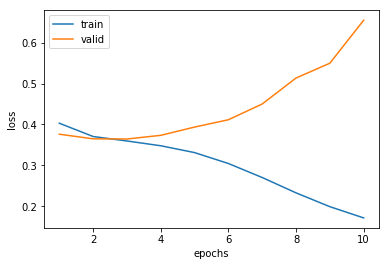

In [104]:
epochs=10
epoch_train_loss=[]
epoch_valid_loss=[]
best_loss=np.inf
for epoch in (range(epochs)):
    hidden=model.init_hidden(batch_size)
    train_loss=0
    valid_loss=0
    batch=0
    ypr=[]
    model.train()
    for a1,a2,a3,a4,a5,a6,a7,labels in get_batches(train_essay_ints,train_school_state_ints,train_grades_ints,train_categories_ints,train_sub_categories_ints,train_teacher_ints,train_remain_features,train_expected):
        batch+=1
        model.zero_grad()
        a7=a7.float()
        a7=a7.view(-1,1,num_features)
        #hidden=tuple([each.data for each in hidden])
        hidden=model.init_hidden(batch_size)
        out=model(a1,a2,a3,a4,a5,a6,a7,hidden)
        loss = criterion(out.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(),5)#gradient clipping
        optimizer.step()
        train_loss+=loss.item()
        out=out.cpu().detach().numpy()
        ypr.extend(list(out.squeeze()))
    train_auc=roc_auc_score(y_train[:len(ypr)],ypr)
    train_loss/=batch
    epoch_train_loss.append(train_loss)
    model.eval()
    batch=0
    ypr=[]
    with torch.no_grad():
        hidden=model.init_hidden(batch_size)
        for a1,a2,a3,a4,a5,a6,a7,labels in get_batches(valid_essay_ints,valid_school_state_ints,valid_grades_ints,valid_categories_ints,valid_sub_categories_ints,valid_teacher_ints,valid_remain_features,valid_expected):
            batch+=1
            #hidden=tuple([each.data for each in hidden])
            hidden=model.init_hidden(batch_size)
            a7=a7.float()
            a7=a7.view(-1,1,num_features)
            out=model(a1,a2,a3,a4,a5,a6,a7,hidden)
            loss = criterion(out.squeeze(), labels.float())
            valid_loss+=loss.item()
            out=out.cpu().detach().numpy()
            ypr.extend(list(out.squeeze()))
        val_auc=roc_auc_score(y_valid[:len(ypr)],ypr)
        valid_loss/=batch
        if best_loss>valid_loss:
                torch.save(model,'best_model3.pth')
                best_loss=valid_loss
        epoch_valid_loss.append(valid_loss)
        print('epoch : {:2} train_loss : {:10.6f} valid_loss: {:10.6f} train_auc {:10.6f} val_auc {:10.6f} '.format(epoch+1,train_loss,valid_loss,train_auc,val_auc))
    
    
plt.plot(range(1,epochs+1),epoch_train_loss,label='train')
plt.plot(range(1,epochs+1),epoch_valid_loss,label='valid')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

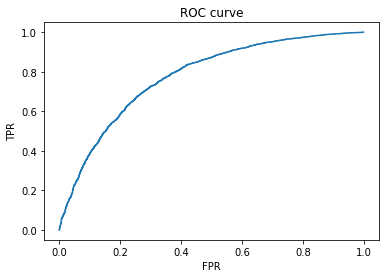

area under curve is 0.7765743484112861


In [105]:
model=torch.load('best_model3.pth')
y_pred=[]
model.eval()
with torch.no_grad():
    hidden=model.init_hidden(batch_size)
    for a1,a2,a3,a4,a5,a6,a7,labels in get_batches(test_essay_ints,test_school_state_ints,test_grades_ints,test_categories_ints,test_sub_categories_ints,test_teacher_ints,test_remain_features,test_expected):
            batch+=1
            hidden=model.init_hidden(batch_size)
            a7=a7.float()
            a7=a7.view(-1,1,num_features)
            out=model(a1,a2,a3,a4,a5,a6,a7,hidden).cpu().detach().numpy()
            y_pred.extend(list(out.squeeze()))
test_fpr, test_tpr, te_thresholds = roc_curve(y_test[:len(y_pred)], y_pred)
plt.plot(test_fpr,test_tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()
model3_auc=roc_auc_score(y_test[:len(y_pred)],y_pred)
print("area under curve is "+str(model3_auc))

In [106]:
from prettytable import PrettyTable
import prettytable
x=PrettyTable()
x.hrules=prettytable.ALL
x.left_padding_width=12
x.right_padding_width=12
x.field_names=['Model','AUC']
x.add_row(['LSTM model-1',model1_auc])
x.add_row(['LSTM model-2',model2_auc])
x.add_row(['LSTM MOdel-3',model3_auc])


print(x)

+------------------------------------+------------------------------------------+
|               Model                |                   AUC                    |
+------------------------------------+------------------------------------------+
|            LSTM model-1            |            0.7569791889649025            |
+------------------------------------+------------------------------------------+
|            LSTM model-2            |            0.7516293335499038            |
+------------------------------------+------------------------------------------+
|            LSTM MOdel-3            |            0.7765743484112861            |
+------------------------------------+------------------------------------------+
